# EN2550 Ex09
# 190432J
# Pathirana R.P.U.A.


([], [])

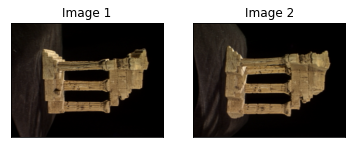

In [18]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

f = open(r'./templeSparseRing/templeSR_par.txt','r')
assert f is not None
n = int (f.readline())
l = f.readline().split()
im1_fn = l[0]  # im1 file name

K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Reading the information on the second image

l = f.readline().split()
im2_fn = l[0] # im2 file name 
 
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Read the two image sand show
im1 =  cv.imread(r'./templeSparseRing/'+ im1_fn , cv.IMREAD_COLOR)
im2 =  cv.imread(r'./templeSparseRing/'+ im2_fn , cv.IMREAD_COLOR)
fig , ax =  plt.subplots(1,2)
ax[0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[0].set_title('Image 1')
ax[0].set_xticks([]), ax[0].set_yticks([])

ax[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
ax[1].set_title('Image 2')
ax[1].set_xticks([]), ax[1].set_yticks([])


In [33]:
sift = cv.xfeatures2d.SIFT_create()
kp1 , decs1 = sift.detectAndCompute(im1,None)
kp2 , decs2 = sift.detectAndCompute(im2,None)

FLANN_INDEX_KDTREE = 1
index_paras = dict(algorithm = FLANN_INDEX_KDTREE , trees =5 )
search_paras = dict(checks = 100)
flann =  cv.FlannBasedMatcher(index_paras,search_paras)
matches = flann.knnMatch(decs1,decs2, k=2)

good =[]
pts1 = []
pts2 = []

for i , (m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)


pts1 = np.array(pts1)
pts2 = np.array(pts2)

F,mask = cv.findFundamentalMat(pts1,pts2, cv.FM_RANSAC)  # Fundamental matrix

print(F)

[[ 1.49034037e-06  1.44154168e-05 -2.53948320e-02]
 [-8.25788252e-06  8.67005344e-08  4.00767127e-03]
 [ 2.27526901e-02 -7.28270380e-03  1.00000000e+00]]


In [34]:
# Essential matrix 
E = K2.T @ K1

print(E)

[[2311616.16         0.      459647.328 ]
 [      0.     2328370.81    376698.933 ]
 [ 459647.328   376698.933   152343.1793]]


In [43]:
 retval,R, t, mask = cv.recoverPose(E, pts1,pts2, K1) 

 R_t_1 = np.concatenate((R1,t1), axis = 1 ) # 3 x 4 matrix
 R2 = R1 @ R
 t2 = R1 @ t
 R_t_2 = np.concatenate((R2, t2), axis = 1)  # 3 x 4  matrix  
 
 P1 = K1 @ np.hstack((R1,t1))  # First camera matrix read form file
 P2_ = K2 @ R_t_2   # second camera matrix estimated from the fundamental matrix computed via point matches
 

 print(P2_)

[[-1.15350563e+03  6.00156470e+01 -1.03384546e+03  7.88687914e+02]
 [ 1.73177671e+02  1.52579596e+03 -1.76838351e+02  4.43777647e+02]
 [ 5.09390489e-01  4.24769651e-03 -8.60525006e-01  9.32354082e-01]]


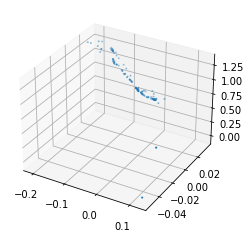

In [50]:
points4d = cv.triangulatePoints(P1 ,P2_ ,pts1.T , pts2.T )
points4d /= points4d[3,:]

X = points4d[0,:]
Y = points4d[1,:]
Z = points4d[2,:]

fig = plt.figure(1)
ax = fig.add_subplot(111, projection= '3d' )

ax.scatter(X,Y,Z , s = 1 ,cmap = 'gray')
plt.show()